In [182]:
### Author : Emanuele Migliaccio and Marco Venditti
### Date   : June 2024
### Description : Credit Spread Estimation based on Macroeconomic and Climate Factors and Copula Simulations


import pandas as pd
import numpy as np
import Yield_Curve_Functions as ycf
import statsmodels.api as sm
from scipy.stats import norm
import yfinance as yf
import copulas
from copulas.multivariate import GaussianMultivariate
import matplotlib.pyplot as plt


R = 0.4 # Recovery Rate


In [183]:
# Load CDS from csv file and check unique companies
cds_data = pd.read_csv('/Users/emanuelemigliaccio/Climate-Risk-Project/data/cds.csv')
cds_data['Company'].unique()

array(['Agilent Technologies Inc', 'Anglo American PLC', 'Apple Inc',
       'ABB Ltd', 'AbbVie Inc', 'AmerisourceBergen Corp',
       'Abertis Infraestructuras SA', 'Anheuser Busch InBev SA NV',
       'Abbott Laboratories', 'Barrick Gold Corp', 'Credit Agricole',
       'ACEA SpA', 'Accor SA', 'Adecco Group AG', 'ADLER Real Estate AG',
       'Archer-Daniels-Midland Co', 'Koninklijke Ahold Delhaize NV',
       'Automatic Data Processing Inc', 'adidas AG', 'Aegon NV',
       'The AES Corporation', 'Aetna Inc', 'American Financial Group Inc',
       'African Export-Import Bank', 'Avangrid Inc',
       'Agricultural Bank of China Ltd', 'Ageas', 'Air Liquide SA',
       'American International Group Inc', 'Airbus SE', 'Akzo Nobel NV',
       'Allstate Corp', 'Alliander NV', 'Ally Financial Inc', 'Alstom SA',
       'Alpha Bank AE', 'Allianz SE', 'Applied Materials Inc',
       'Amgen Inc', 'Ameriprise Financial Inc', 'American Tower Corp',
       'America Movil SAB de CV', 'Amazon.com In

/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_1009/470910273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_cds['Date'] = pd.to_datetime(company_cds['Date'])


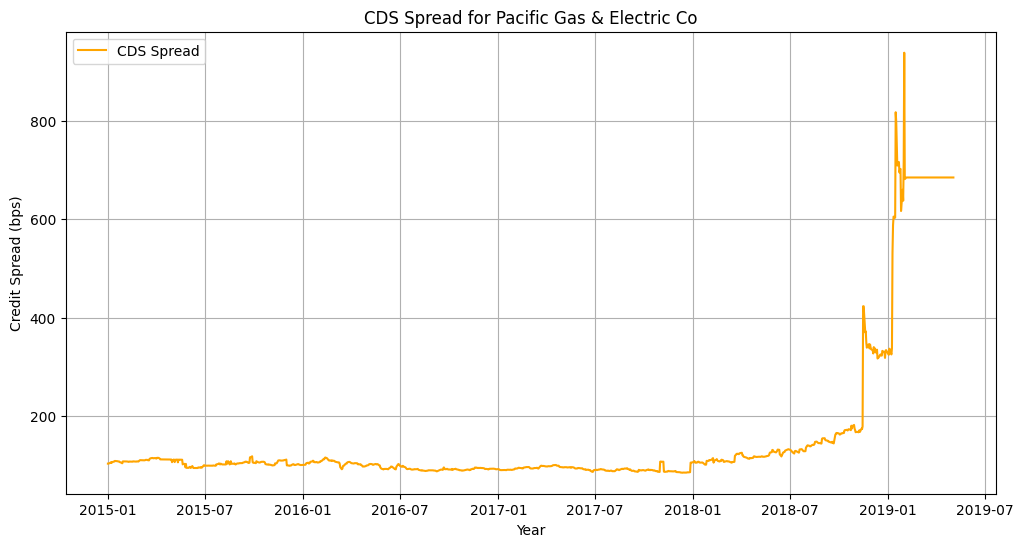

In [184]:
# Plot the time series of CDS spreads for Pacific Gas & Electric Co
company_cds = cds_data[cds_data['Company'] == 'Pacific Gas & Electric Co']
company_cds['Date'] = pd.to_datetime(company_cds['Date'])
company_cds.set_index('Date', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(company_cds.index, company_cds['PX10'], label='CDS Spread', color='orange')
plt.title('CDS Spread for Pacific Gas & Electric Co')
plt.xlabel('Year')
plt.ylabel('Credit Spread (bps)')
plt.legend()
plt.grid()
plt.show()



In [185]:
# Estimate hazard rate for Pacific Gas & Electric Co using CDS 10Y spreads
cds_company = cds_data[cds_data['Company'] == 'Pacific Gas & Electric Co'].copy()
cds_company = cds_company.drop(columns=['Ticker','Company'])
cds_company = cds_company.set_index('Date')
cds_company1y = cds_company['PX10']
cds_company1y = cds_company1y / 10000  # Convert bps to decimal
lambda_1y = cds_company1y / (1 - R)  # Hazard rate estimation


In [186]:
# Calculate Through-The-Cycle 1-Year PD using average hazard rate
pd_1y_daily = 1.0 - np.exp(-lambda_1y)
pd_1y_daily.index = pd.to_datetime(pd_1y_daily.index)
pd_1y_yearly = pd_1y_daily.groupby(pd_1y_daily.index.year).mean()
pd_TTC = pd_1y_yearly.mean()
print(f'Through-The-Cycle 1-Year PD for Pacific Gas & Electric Co: {pd_TTC:.4%}')

Through-The-Cycle 1-Year PD for Pacific Gas & Electric Co: 3.5782%


In [187]:
# Data preparation for climate data frame : Scenario SSP1 - 1.9

IPCC_CSV_PATH = "/Users/emanuelemigliaccio/Climate-Risk-Project/data/owid_ipcc_scenarios.csv"

df_ssp_raw = pd.read_csv(IPCC_CSV_PATH)
df_ssp = df_ssp_raw[df_ssp_raw["Scenario"] == "SSP5 - 6.0"].copy()
df_ssp = df_ssp.set_index("Year")

In [188]:
# Interpolate climate data from 2005 to 2100 yearly
years = np.arange(2005, 2101)
df_ssp = df_ssp.reindex(years)
df_ssp.interpolate(method='linear', inplace=True)
df_ssp = df_ssp.reset_index().rename(columns={"index": "Year"})
df_ssp.head()

/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_1009/216790850.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_ssp.interpolate(method='linear', inplace=True)


,Year,Scenario,Crop demand,Energy crop demand,Livestock demand,Energy crop production,Non-energy crop production,Livestock production,Carbon price,Methane concentration,...,Carbon intensity of energy,Primary energy intensity,Final energy intensity,Final energy as a share of primary energy,final_energy_biomass,final_energy_coal,final_energy_solar,annotation,primary_energy_intensity,final_energy_intensity
0,2005,SSP5 - 6.0,NaN,25325500.0,205757500.0,25325500.0,3.327677e+09,205757500.0,0.0,1753.1600,...,0.272983,2.276515,1.620412,71.179509,48.46,36.600,NaN,Fossil-fueled Development - Taking the Highway,0.008195,0.005833
1,2006,NaN,NaN,22503160.0,211694980.0,22503160.0,3.413904e+09,211694980.0,0.0,1765.1008,...,0.270428,2.234529,1.589360,71.123038,48.78,37.492,NaN,NaN,0.008044,0.005722
2,2007,NaN,NaN,19680820.0,217632460.0,19680820.0,3.500130e+09,217632460.0,0.0,1777.0416,...,0.267872,2.192542,1.558307,71.066568,49.10,38.384,NaN,NaN,0.007893,0.005610
3,2008,NaN,NaN,16858480.0,223569940.0,16858480.0,3.586357e+09,223569940.0,0.0,1788.9824,...,0.265317,2.150556,1.527254,71.010097,49.42,39.276,NaN,NaN,0.007742,0.005498
4,2009,NaN,NaN,14036140.0,229507420.0,14036140.0,3.672583e+09,229507420.0,0.0,1800.9232,...,0.262762,2.108569,1.496201,70.953626,49.74,40.168,NaN,NaN,0.007591,0.005386


In [189]:
# Select relevant columns for analysis
cols = ["Carbon price", "Temperature"]
df_ssp1_19 = df_ssp[["Year"] + cols].copy()


In [190]:
# Load yield forecasting data for SSP1 scenario and preprocess it
yield_ssp1 = pd.read_csv('/Users/emanuelemigliaccio/Climate-Risk-Project/data/yield_forecasting_ssp5.csv', index_col=0)

# Interpolate yield data from 2005 to 2100 yearly
yield_ssp1 = yield_ssp1.reindex(years)
yield_ssp1.interpolate(method='linear', inplace=True)
yield_ssp1 = yield_ssp1.reset_index().rename(columns={"index": "Year"})
yield_ssp1.head()

,Year,1.0,2.0,3.0,5.0,7.0,10.0,20.0,30.0
0,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
# Add yield data to climate data frame
df_ssp1_19['yield'] = yield_ssp1['10.0']
#Set Year as index
df_ssp1_19 = df_ssp1_19.set_index('Year')

In [192]:
#Standardize the variables
df_ssp1_19['z_yield'] = (df_ssp1_19['yield'] - df_ssp1_19['yield'].mean()) / df_ssp1_19['yield'].std()
df_ssp1_19['z_Carbon_Price'] = (df_ssp1_19['Carbon price'] - df_ssp1_19['Carbon price'].mean()) / df_ssp1_19['Carbon price'].std()
df_ssp1_19['z_Temperature'] = (df_ssp1_19['Temperature'] - df_ssp1_19['Temperature'].mean()) / df_ssp1_19['Temperature'].std()



In [193]:
# Drop original columns and handle missing values
df_ssp1_19 = df_ssp1_19.drop(columns=['yield','Carbon price','Temperature'])
df_ssp1_19 = df_ssp1_19.dropna()

In [194]:
# Calculate correlation matrix
rho = df_ssp1_19.corr()

In [195]:
# Define macro sensitivity betas and calculate asset threshold
beta_macro_sensitive = np.array([0.25, 0.30, 0.10])
a = norm.ppf(pd_TTC)

In [196]:
# Estimate the conditional pd using SSP 1.9 scenario
pd_conditional = norm.cdf((a - df_ssp1_19.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
lambda_conditional = -np.log(1 - pd_conditional) # Convert PD to hazard rate for 1 year
spread_conditional = lambda_conditional * (1 - R) * 10000  # Convert to bps

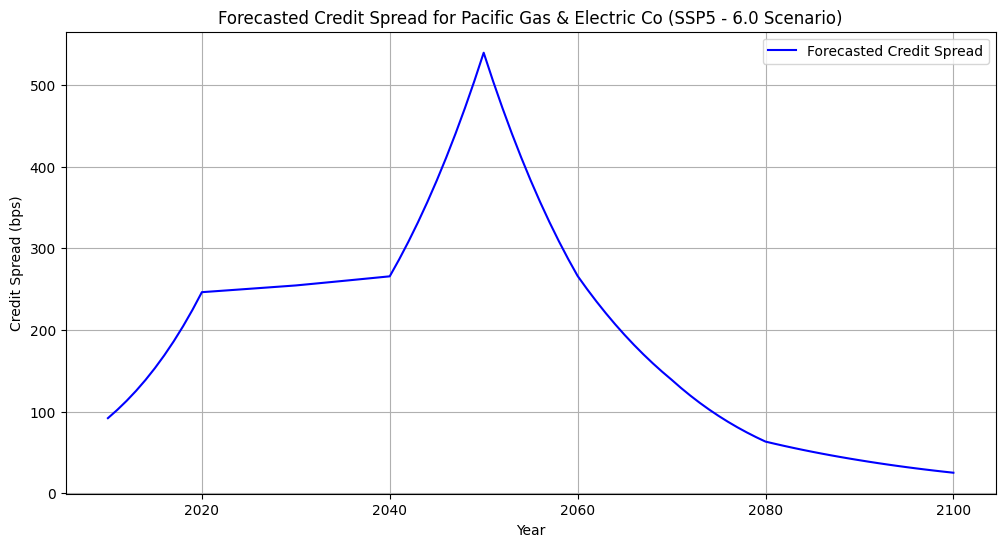

In [197]:
# Plot Credit Spread Forecasted
plt.figure(figsize=(12, 6))
plt.plot(df_ssp1_19.index, spread_conditional, label='Forecasted Credit Spread', color='blue')
plt.title('Forecasted Credit Spread for Pacific Gas & Electric Co (SSP5 - 6.0 Scenario)')
plt.xlabel('Year')
plt.ylabel('Credit Spread (bps)')
plt.legend()
plt.grid()
plt.show()

In [198]:
# Add spread to yield curve
df_ssp1_19['Credit Spread'] = spread_conditional
yield_ssp1 = yield_ssp1.set_index('Year')
df_ssp1_19['Yield with CS'] = yield_ssp1['10.0'] + df_ssp1_19['Credit Spread']/100
df_ssp1_19['Yield wo CS'] = yield_ssp1['10.0'] 


In [199]:
print(df_ssp1_19[['Yield with CS','Yield wo CS']].head())
print((df_ssp1_19['Yield with CS'] - df_ssp1_19['Yield wo CS']).describe())


      Yield with CS  Yield wo CS
Year                            
2010       7.041102     6.120937
2011       7.022551     6.000588
2012       7.013599     5.880239
2013       7.014960     5.759889
2014       7.027381     5.639540
count    91.000000
mean      2.012987
std       1.331286
min       0.251847
25%       0.777268
50%       2.069103
75%       2.628634
max       5.395215
dtype: float64


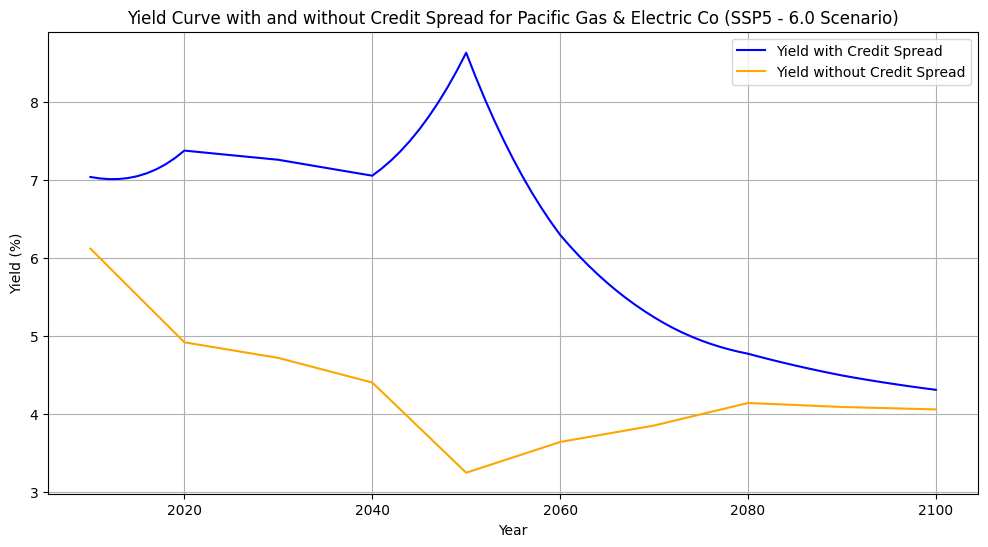

In [200]:
# Plort the yield curve with credit spread vs without credit spread
plt.figure(figsize=(12, 6))
plt.plot(df_ssp1_19.index, df_ssp1_19['Yield with CS'], label='Yield with Credit Spread', color='blue')
plt.plot(df_ssp1_19.index, df_ssp1_19['Yield wo CS'], label='Yield without Credit Spread', color='orange')
plt.title('Yield Curve with and without Credit Spread for Pacific Gas & Electric Co (SSP5 - 6.0 Scenario)')
plt.xlabel('Year')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

In [201]:
# Let's try to fit a copula to fit climate variables in order to generate scenarios
df_ssp1_19_copula = df_ssp1_19[['z_yield', 'z_Carbon_Price', 'z_Temperature']]

model = GaussianMultivariate()
model.fit(df_ssp1_19_copula)

samples = model.sample(1000)


/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6363: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)


In [202]:
#Trying t-student copula 
# Source - https://www.ressources-actuarielles.net/EXT/ISFA/1226.nsf/0/303eb11b4d617b79c1257b0800744575/$FILE/t%20copula%20demarta%20mcneil.pdf

from scipy.stats import invgamma, chi2, t

#Define number of sampling points
n_samples = 10000
df = 8

mu = np.zeros(len(rho))

s = chi2.rvs(df, size=n_samples)[:, np.newaxis]
#s = invgamma.pdf(df/2,df/2) 
Z = np.random.multivariate_normal(mu, rho,n_samples)
X = np.sqrt(df/s)*Z #chi-square method
#X = np.sqrt(s)*Z #inverse gamma method

U = t.cdf(X,df)


U_df = pd.DataFrame(U)
U_df.columns = ['z_yield', 'z_Carbon_Price', 'z_Temperature']
corr_simulated_tstudent = U_df.corr()


In [203]:
# Inverse Transform Sampling to get back to original variables

def empirical_inverse_cdf(data):
    # Build empirical CDF
    sorted_data = np.sort(data)
    def inv_cdf(u):
        idx = (u * (len(sorted_data)-1)).astype(int)
        return sorted_data[idx]
    return inv_cdf


inv_yield = empirical_inverse_cdf(df_ssp1_19_copula['z_yield'])
inv_carbon = empirical_inverse_cdf(df_ssp1_19_copula['z_Carbon_Price'])
inv_temp = empirical_inverse_cdf(df_ssp1_19_copula['z_Temperature'])

sim_yield = inv_yield(U_df['z_yield'].values)
sim_carbon = inv_carbon(U_df['z_Carbon_Price'].values)
sim_temp = inv_temp(U_df['z_Temperature'].values)

plot_df = pd.DataFrame({
    'z_yield': sim_yield,
    'z_Carbon_Price': sim_carbon,
    'z_Temperature': sim_temp
})



<Figure size 1450x1050 with 0 Axes>

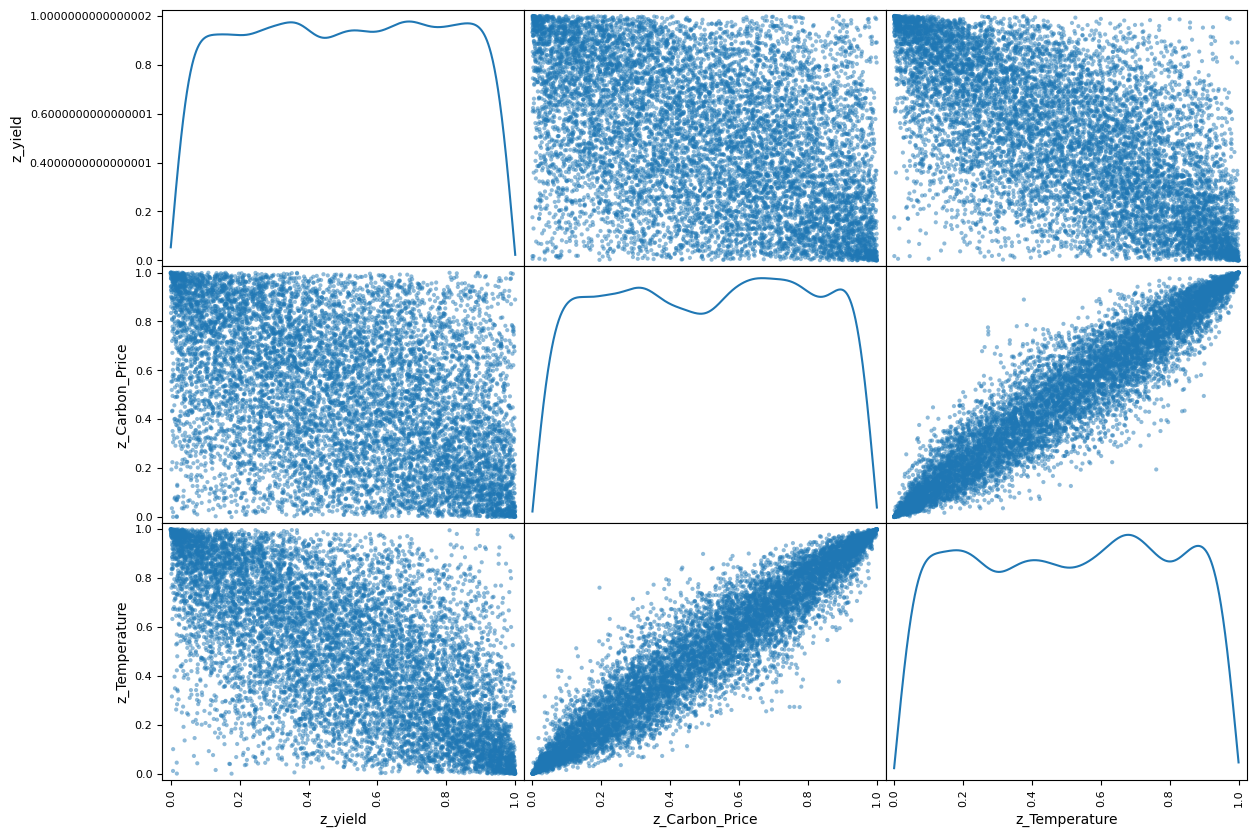

In [204]:
# Scatter matrix plot of simulated variables

fig = plt.gcf()
fig.set_size_inches(14.5, 10.5)
pd.plotting.scatter_matrix(U_df, figsize=(14,10), diagonal = 'kde')
plt.show()


In [205]:
# Let's compare the correlation matrix of the original data vs the simulated data
corr_original = df_ssp1_19_copula.corr()
corr_simulated = samples.corr()
print("Original Correlation Matrix:\n", corr_original)
print("Simulated Correlation Matrix:\n", corr_simulated)
print("Simulated Correlation Matrix t-Student:\n", corr_simulated_tstudent)

Original Correlation Matrix:
                  z_yield  z_Carbon_Price  z_Temperature
z_yield         1.000000       -0.472476      -0.694009
z_Carbon_Price -0.472476        1.000000       0.954474
z_Temperature  -0.694009        0.954474       1.000000
Simulated Correlation Matrix:
                  z_yield  z_Carbon_Price  z_Temperature
z_yield         1.000000       -0.283983      -0.315010
z_Carbon_Price -0.283983        1.000000       0.914371
z_Temperature  -0.315010        0.914371       1.000000
Simulated Correlation Matrix t-Student:
                  z_yield  z_Carbon_Price  z_Temperature
z_yield         1.000000       -0.449136      -0.669832
z_Carbon_Price -0.449136        1.000000       0.948074
z_Temperature  -0.669832        0.948074       1.000000


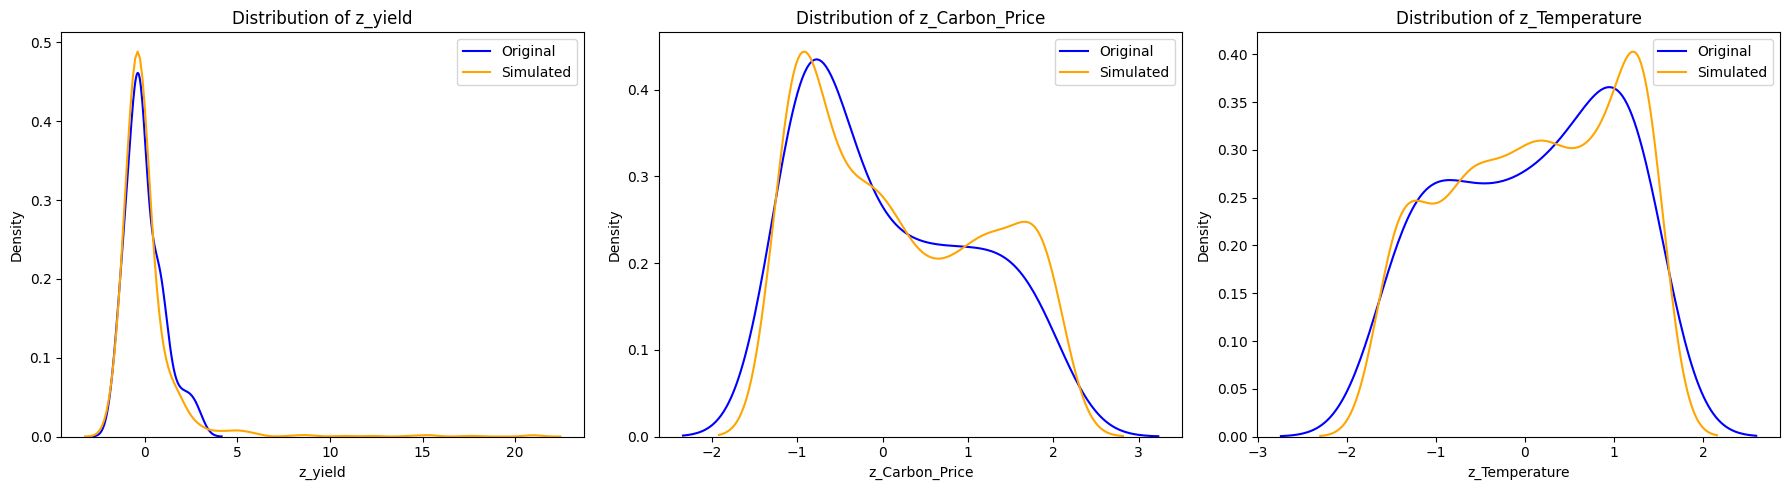

In [206]:
#Let's plot the distributions of the original vs simulated data (Gaussian Copula)
import seaborn as sns
plt.figure(figsize=(18, 5))
for i, col in enumerate(df_ssp1_19_copula.columns):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(df_ssp1_19_copula[col], label='Original', color='blue')
    sns.kdeplot(samples[col], label='Simulated', color='orange')
    plt.title(f'Distribution of {col}')
    plt.legend()
plt.tight_layout()
plt.show()  

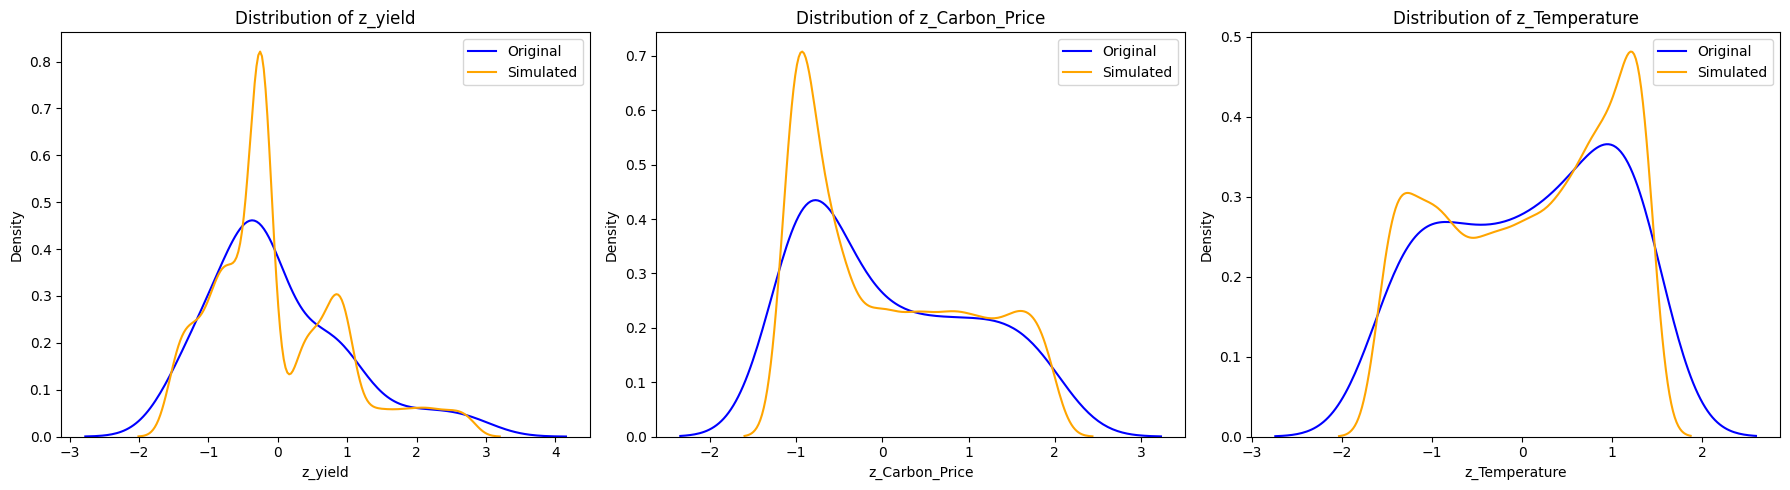

In [207]:
#Let's plot the distributions of the original vs simulated data (t-Student Copula)
import seaborn as sns
plt.figure(figsize=(18, 5))
for i, col in enumerate(df_ssp1_19_copula.columns):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(df_ssp1_19_copula[col], label='Original', color='blue')
    sns.kdeplot(plot_df[col], label='Simulated', color='orange')
    plt.title(f'Distribution of {col}')
    plt.legend()
plt.tight_layout()
plt.show()  

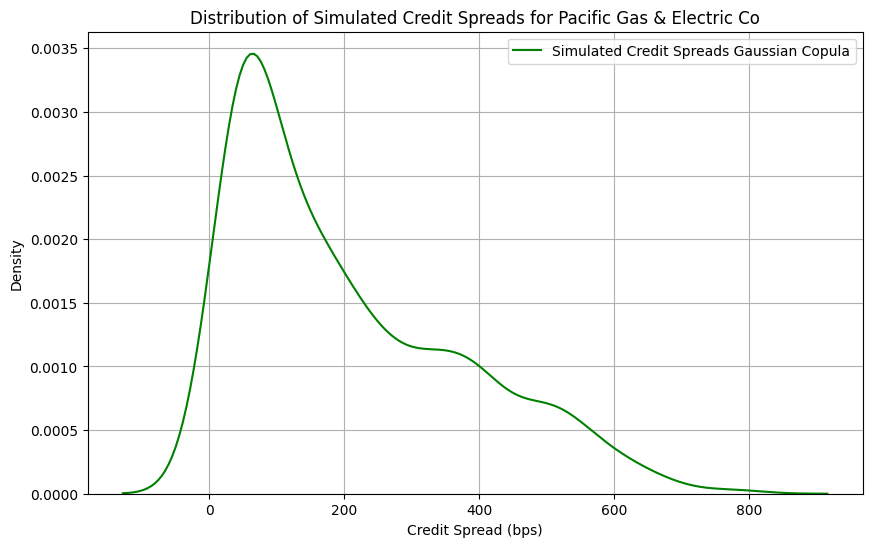

In [210]:
# Now we can use the simulated data to estimate credit spreads under different scenarios (Gaussian Copula)
for i in range(samples.shape[0]):
    simulated_row = samples.iloc[i]
    pd_conditional_sim = norm.cdf((a - simulated_row.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
    lambda_conditional_sim = -np.log(1 - pd_conditional_sim) # Convert PD to hazard rate for 1 year
    spread_conditional_sim = lambda_conditional_sim * (1 - R) 
    # Here you can store or process the spread_conditional_sim as needed


# Plot the distribution of the simulated credit spreads
simulated_spreads = []
for i in range(samples.shape[0]):
    simulated_row = samples.iloc[i]
    pd_conditional_sim = norm.cdf((a - simulated_row.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
    lambda_conditional_sim = -np.log(1 - pd_conditional_sim) # Convert PD to hazard rate for 1 year
    spread_conditional_sim = lambda_conditional_sim * (1 - R) * 10000  # Convert to bps
    simulated_spreads.append(spread_conditional_sim)
plt.figure(figsize=(10, 6))
sns.kdeplot(simulated_spreads, label='Simulated Credit Spreads Gaussian Copula', color='green')
plt.title('Distribution of Simulated Credit Spreads for Pacific Gas & Electric Co')
plt.xlabel('Credit Spread (bps)')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()  




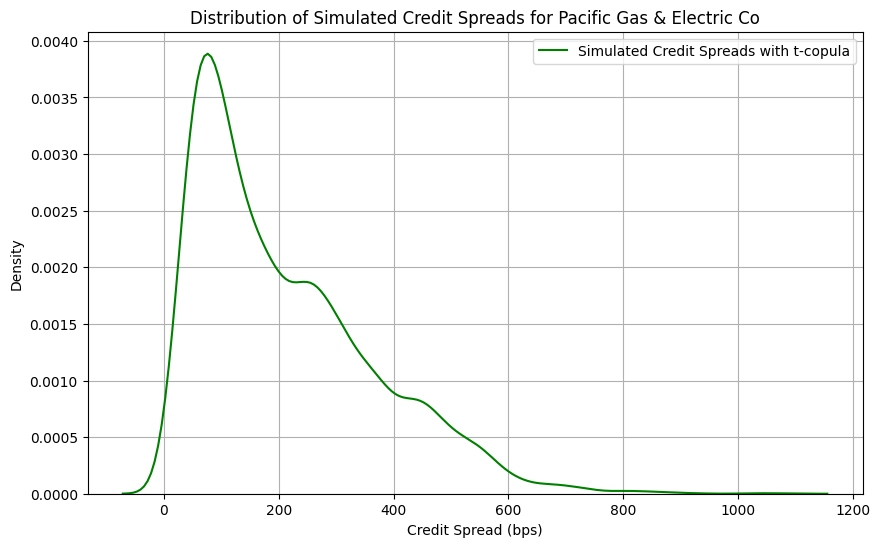

In [212]:
# Now we can use the simulated data to estimate credit spreads under different scenarios (t-Student Copula)
for i in range(samples.shape[0]):
    simulated_row_t = plot_df.iloc[i]
    pd_conditional_sim_t = norm.cdf((a - simulated_row_t.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
    lambda_conditional_sim_t = -np.log(1 - pd_conditional_sim_t) # Convert PD to hazard rate for 1 year
    spread_conditional_sim_t = lambda_conditional_sim_t * (1 - R) 
    # Here you can store or process the spread_conditional_sim as needed


# Plot the distribution of the simulated credit spreads
simulated_spreads_t = []
for i in range(U_df.shape[0]):
    simulated_row_t = plot_df.iloc[i]
    pd_conditional_sim_t = norm.cdf((a - simulated_row_t.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
    lambda_conditional_sim_t = -np.log(1 - pd_conditional_sim_t) # Convert PD to hazard rate for 1 year
    spread_conditional_sim_t = lambda_conditional_sim_t * (1 - R) * 10000  # Convert to bps
    simulated_spreads_t.append(spread_conditional_sim_t)
plt.figure(figsize=(10, 6))
sns.kdeplot(simulated_spreads_t, label='Simulated Credit Spreads with t-copula', color='green')
plt.title('Distribution of Simulated Credit Spreads for Pacific Gas & Electric Co')
plt.xlabel('Credit Spread (bps)')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()  


